# Agentic RAG over Local PDFs (Chroma + LangGraph)

This notebook merges the **PDF embeddings pipeline** from your `rag_local_pdfs.ipynb` with the **agentic RAG / LangGraph** scaffolding from `agentic_rag_xakata_openai-pdfs.ipynb`, but switching the source to **local PDFs** (persisted in Chroma).

## What you get
- Read all PDFs from a directory
- Chunk and embed into a **Chroma** vector store (persisted)
- Build a **retriever**
- Run an **agentic RAG** with **LangGraph** that can:
  1. Retrieve
  2. Grade relevance (LLM-as-a-judge)
  3. Optionally rewrite the query and re-retrieve if needed
  4. Generate an answer with cited chunks


## Requirements

Make sure your environment has (adjust versions to your stack):

```bash
pip install -U   langchain>=0.2.12 langchain-community>=0.2.6 langchain-text-splitters>=0.2.2   langchain-openai>=0.1.20   chromadb>=0.5.4   tiktoken>=0.7.0   pypdf>=4.2.0 PyPDF2>=3.0.1   sentence-transformers>=3.0.1   langgraph>=0.2.35
```

Set your OpenAI key if you use OpenAI models:

```bash
export OPENAI_API_KEY=sk-...
```


In [1]:
pip install -U  -q  langchain>=0.2.12 langchain-community>=0.2.6 langchain-text-splitters>=0.2.2   langchain-openai>=0.1.20   chromadb>=0.5.4   tiktoken>=0.7.0   pypdf>=4.2.0 PyPDF2>=3.0.1   sentence-transformers>=3.0.1   langgraph>=0.2.35

Note: you may need to restart the kernel to use updated packages.


In [2]:
# --- Configuration ---
from dataclasses import dataclass
from pathlib import Path

@dataclass
class Config:
    pdf_dir: str = "docs"              # folder with your PDFs
    persist_dir: str = "chroma_pdf_index"   # where to persist Chroma
    chunk_size: int = 1000
    chunk_overlap: int = 150
    # Embeddings: choose 'openai' or 'sentence-transformers'
    embeddings_backend: str = "openai"      # "openai" | "sentence-transformers"
    st_model_name: str = "all-MiniLM-L6-v2" # only used if embeddings_backend='sentence-transformers'
    # LLMs
    openai_model: str = "gpt-4o-mini"       # for grading & answering
    max_rewrite_iters: int = 1              # how many rewrite rounds allowed

CFG = Config()

Path(CFG.pdf_dir).mkdir(parents=True, exist_ok=True)
Path(CFG.persist_dir).mkdir(parents=True, exist_ok=True)
print(CFG)


Config(pdf_dir='docs', persist_dir='chroma_pdf_index', chunk_size=1000, chunk_overlap=150, embeddings_backend='openai', st_model_name='all-MiniLM-L6-v2', openai_model='gpt-4o-mini', max_rewrite_iters=1)


In [3]:
# --- Imports ---
import os
from typing import List, Dict, Any, Tuple
from pathlib import Path

from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import Chroma

# Embeddings
from langchain_openai import OpenAIEmbeddings
from langchain_community.embeddings import HuggingFaceEmbeddings

# LLMs
from langchain_openai import ChatOpenAI

# LangGraph
from langgraph.graph import StateGraph, END
from typing import TypedDict, Optional

# Utilities
from dataclasses import asdict

from dotenv import load_dotenv
load_dotenv()  # Carga variables de entorno (OPENAI_API_KEY, etc.)


True

## 1) Load & Chunk PDFs

In [4]:
def load_pdfs_from_dir(pdf_dir: str):
    pdf_dir = Path(pdf_dir)
    docs = []
    for pdf_path in sorted(pdf_dir.glob("*.pdf")):
        loader = PyPDFLoader(str(pdf_path))
        docs.extend(loader.load())
    return docs

raw_docs = load_pdfs_from_dir(CFG.pdf_dir)
print(f"Loaded {len(raw_docs)} pages from PDFs in {CFG.pdf_dir!r}")


Loaded 221 pages from PDFs in 'docs'


In [5]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CFG.chunk_size,
    chunk_overlap=CFG.chunk_overlap,
    separators=["\n\n", "\n", " ", ""]
)
chunks = text_splitter.split_documents(raw_docs)
print(f"Created {len(chunks)} chunks.")

Created 421 chunks.


## 2) Build / Load Chroma VectorStore

In [6]:
def get_embeddings(backend: str):
    if backend == "openai":
        return OpenAIEmbeddings()  # uses env var OPENAI_API_KEY
    elif backend == "sentence-transformers":
        return HuggingFaceEmbeddings(model_name=CFG.st_model_name)
    else:
        raise ValueError("Unknown embeddings backend")

embeddings = get_embeddings(CFG.embeddings_backend)

# If there is already a persisted index, load it; else create and persist it
if any(Path(CFG.persist_dir).iterdir()):
    print("Loading existing Chroma index...")
    vectordb = Chroma(persist_directory=CFG.persist_dir, embedding_function=embeddings)
else:
    print("Creating new Chroma index...")
    vectordb = Chroma.from_documents(chunks, embeddings, persist_directory=CFG.persist_dir)
    vectordb.persist()

retriever = vectordb.as_retriever(search_kwargs={"k": 6})
retriever


Loading existing Chroma index...


C:\Users\xavi.marti_bluetab\AppData\Local\Temp\ipykernel_28732\915179317.py:14: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the `langchain-chroma package and should be used instead. To use it run `pip install -U `langchain-chroma` and import as `from `langchain_chroma import Chroma``.
  vectordb = Chroma(persist_directory=CFG.persist_dir, embedding_function=embeddings)


VectorStoreRetriever(tags=['Chroma', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x000001F0EB24BA10>, search_kwargs={'k': 6})

In [7]:
query = "¿Cuál es el propósito principal del documento?"
results = retriever.invoke(query)

for i, doc in enumerate(results, 1):
    print(f"\nDocumento {i}:\n{doc.page_content[:500]}...\nFuente: {doc.metadata.get('source')}")



Documento 1:
Iceberg logo are trademarks of the Apache Software Foundation.
Learning Objectives
● Describe real-time deployment and identify scenarios in which this 
method is required.
● Discuss challenges of real-time deployment systems.
● Describe features of Databricks Model Serving.
● Discuss a typical real-time model deployment workﬂow on Databricks.
● Serve a model with model serving using the UI and the API....
Fuente: docs\generative-ai-deployment-and-monitoring.pdf

Documento 2:
Iceberg logo are trademarks of the Apache Software Foundation.
The Gen AI System Lifecycle
Business 
Problem
Deﬁne Success 
Criteria Data Collection AI System (RAG / 
Chain) Building
AI System
Evaluation
Data 
Preprocessing
AI System 
Deployment
AI System 
Monitoring
System Development 
(use static data)
Deployment & Production
(deal with continuously changing 
new data)
Your AI System is ready, then what?...
Fuente: docs\generative-ai-deployment-and-monitoring.pdf

Documento 3:
Iceberg logo are trad

## 3) Agentic RAG with LangGraph

The graph implements:
- **retrieve** → **grade_docs** → if all bad → **rewrite_query** → **retrieve** again (1 round) → **generate**.


In [8]:
class AgentState(TypedDict):
    question: str
    rewritten_question: Optional[str]
    docs: list
    judged_docs: list
    answer: Optional[str]
    citations: list
    rewrite_iters: int


In [9]:
llm = ChatOpenAI(model=CFG.openai_model, temperature=0)  # deterministic for grading/answer

In [10]:
def node_retrieve(state: AgentState) -> AgentState:
    q = state.get("rewritten_question") or state["question"]
    # En LC 0.2+:
    docs = retriever.invoke(q)          # <- en lugar de get_relevant_documents
    return {**state, "docs": docs}

In [11]:
from langchain_core.prompts import ChatPromptTemplate

grading_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a strict relevance judge. Score each document 0 (irrelevant) or 1 (relevant) for the query."),
    ("human", "Query: {query}\n\nDocument:\n{content}\n\nReturn just 0 or 1."),
])

def grade_doc(query: str, content: str) -> int:
    msg = grading_prompt.format_messages(query=query, content=content[:4000])
    out = llm.invoke(msg).content.strip()
    return 1 if out.startswith("1") else 0

def node_grade_docs(state: AgentState) -> AgentState:
    q = state.get("rewritten_question") or state["question"]
    judged = []
    for d in state["docs"]:
        score = grade_doc(q, d.page_content)
        judged.append((d, score))
    return {**state, "judged_docs": judged}


In [12]:
def need_rewrite(state: AgentState) -> bool:
    scores = [s for _, s in state.get("judged_docs", [])]
    if not scores:
        return True
    # rewrite if all 0 or average < 0.34
    avg = sum(scores) / len(scores)
    return avg < 0.34


In [13]:
rewrite_prompt = ChatPromptTemplate.from_messages([
    ("system", "Rewrite the user's query to maximize retrieval of relevant documents from a knowledge base of local PDFs. Keep it concise."),
    ("human", "Original query: {query}\nProvide a single improved query:"),
])

def node_rewrite_query(state: AgentState) -> AgentState:
    print("node_rewrite_query")
    q = state.get("rewritten_question") or state["question"]
    if state["rewrite_iters"] >= CFG.max_rewrite_iters:
        return state  # no more rewrites
    msg = rewrite_prompt.format_messages(query=q)
    new_q = llm.invoke(msg).content.strip()
    return {**state, "rewritten_question": new_q, "rewrite_iters": state["rewrite_iters"] + 1}


In [14]:
answer_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful analyst. Answer the question **only** using the provided documents. Cite using [#] markers mapping to 'source' metadata."),
    ("human", "Question: {query}\n\nUse these documents (format: [#] content | source):\n\n{docs}\n\nAnswer with citations:")
])

def format_docs(judged_docs):
    # keep only relevant
    filtered = [(d, s) for (d, s) in judged_docs if s == 1]
    if not filtered:
        # if none relevant, allow using all docs but say no strong evidence
        filtered = judged_docs
    lines, cites = [], []
    for i, (d, _) in enumerate(filtered, 1):
        src = d.metadata.get("source") or d.metadata.get("file_path") or d.metadata.get("pdf") or "pdf"
        lines.append(f"[{i}] {d.page_content[:800].replace('\n',' ')} | {src}")
        cites.append(src)
    return "\n\n".join(lines), cites

def node_generate(state: AgentState) -> AgentState:
    q = state.get("rewritten_question") or state["question"]
    listing, cites = format_docs(state["judged_docs"])
    msg = answer_prompt.format_messages(query=q, docs=listing if listing else "(no docs)")
    ans = llm.invoke(msg).content
    return {**state, "answer": ans, "citations": cites}


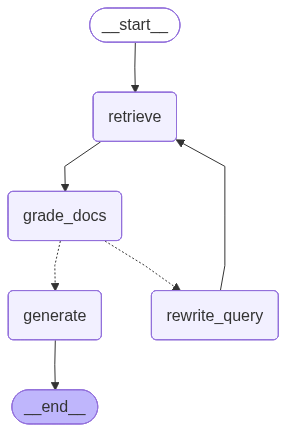

In [15]:
workflow = StateGraph(AgentState)

workflow.add_node("retrieve", node_retrieve)
workflow.add_node("grade_docs", node_grade_docs)
workflow.add_node("rewrite_query", node_rewrite_query)
workflow.add_node("generate", node_generate)

workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_docs")

# Conditional: rewrite or go generate
def route_after_grade(state: AgentState):
    if need_rewrite(state):
        return "rewrite_query"
    return "generate"

workflow.add_conditional_edges("grade_docs", route_after_grade, {"rewrite_query": "rewrite_query", "generate": "generate"})
# After rewrite, always retrieve again, then grade -> generate
workflow.add_edge("rewrite_query", "retrieve")
workflow.add_edge("generate", END)

graph = workflow.compile()
graph


## 4) Run the Agent

In [16]:
def run_agent(question: str) -> Dict[str, Any]:
    state: AgentState = {
        "question": question,
        "rewritten_question": None,
        "docs": [],
        "judged_docs": [],
        "answer": None,
        "citations": [],
        "rewrite_iters": 0,
    }
    final = graph.invoke(state)
    return final

# Example (edit the question to your PDFs content)
result = run_agent("¿Qué temperatura hace en Alicante")
print(result["answer"])

node_rewrite_query
node_rewrite_query
node_rewrite_query
node_rewrite_query
node_rewrite_query
node_rewrite_query
node_rewrite_query
node_rewrite_query


GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://docs.langchain.com/oss/python/langgraph/errors/GRAPH_RECURSION_LIMIT

In [ ]:
def ask(question: str):
    res = run_agent(question)
    print("\n=== ANSWER ===\n")
    print(res["answer"]) 
    if res.get("rewritten_question"): 
        print("\n(Rewritten query)", res["rewritten_question"]) 
    print("\nCitations:", list(dict.fromkeys(res.get("citations", []))))

ask("Que son los flavours de MLOPS?")